# Imports

In [361]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [362]:
import re
import seaborn as sns
import tensorflow as tf

In [363]:
from wordcloud import WordCloud

In [364]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

## Loading the Data

In [365]:
target = ['sentiment', 'text']
df = pd.read_csv('../../data/raw/sentimentDataset/test.csv',
                encoding='ISO-8859-1',
                usecols=target)
df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [366]:
print(df.shape)
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.info())

(4815, 2)
text         1281
sentiment    1281
dtype: int64
1280
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 75.4+ KB
None


In [367]:
print(df['sentiment'].isna().sum())
print(df['sentiment'].isnull().sum())

1281
1281


In [368]:
df['sentiment'] = df['sentiment'].fillna('neutral')

In [369]:
def clean(text):
    text = re.sub(r'[^\w\s]', '', text)
    # Conver to lower
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [370]:
df['text'] = df['text'].fillna('')
df['text'] = df['text'].apply(clean)

In [371]:
for i in range(10):
    print(df['text'][i+1])

shanghai is also really exciting precisely skyscrapers galore good tweeps in china sh bj
recession hit veronique branquinho she has to quit her company such a shame
happy bday
httptwitpiccom4w75p i like it
thats great weee visitors
i think everyone hates me on here lol
soooooo wish i could but im in school and myspace is completely blocked
and within a short time of the last clue all of them
what did you get my day is alright havent done anything yet leaving soon to my stepsister though
my bike was put on holdshould have known that argh total bummer


# Data Exploration 

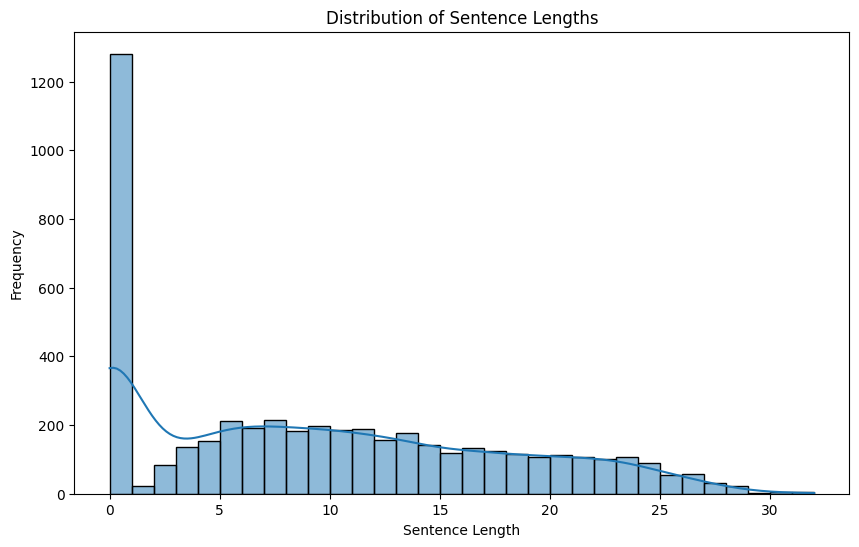

In [372]:
# sentence-length distribution
senLen = [len(text.split()) for text in df['text']]
plt.figure(figsize=(10, 6))
sns.histplot(senLen, bins=range(min(senLen), max(senLen) + 1, 1), kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

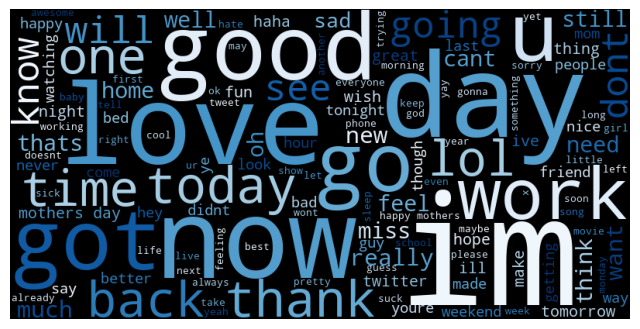

In [373]:
# worlCloud for all texts
allText = ' '.join(df['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Blues').generate(allText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

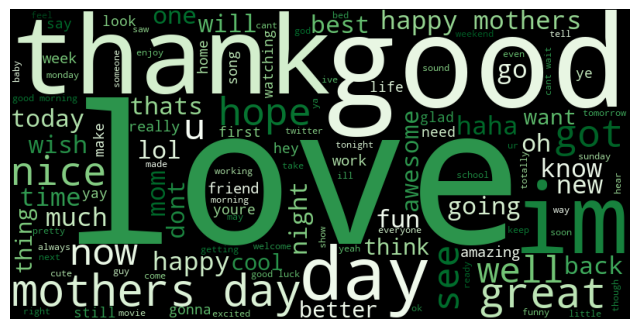

In [374]:
# worlCloud for positive texts
posText = ' '.join(df[df['sentiment'] == 'positive']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Greens').generate(posText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

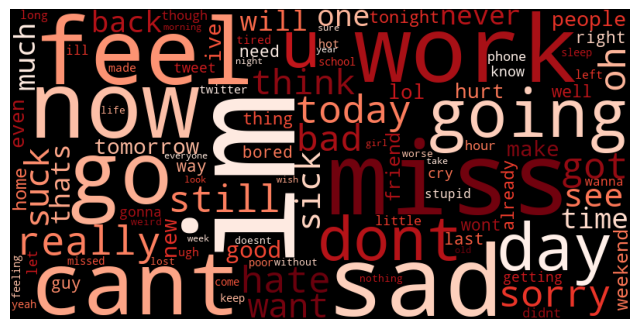

In [375]:
# worlCloud for negative texts
negText = ' '.join(df[df['sentiment'] == 'negative']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Reds').generate(negText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

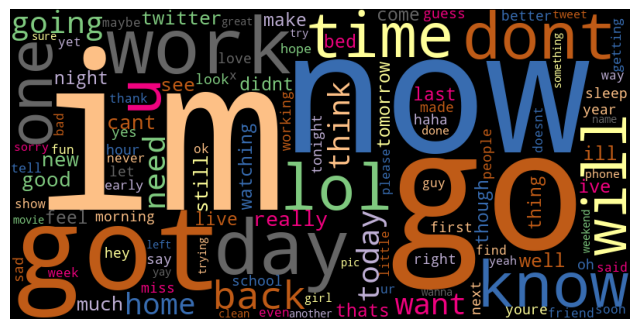

In [376]:
# worlCloud for neutral texts
neuText = ' '.join(df[df['sentiment'] == 'neutral']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Accent').generate(neuText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

# Tokenization, Padding, Labeling Target, Data Spliting (without lemmatization and stopwords)

In [377]:
#Tokenizing Text
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(df['text'])
sequence = tokenizer.texts_to_sequences(df['text'])

In [378]:
#Padding the Sequences
maxLength = int(np.percentile(([len(text.split()) for text in df['text']]), 95))
paddedSeq = pad_sequences(sequence, maxLength, padding='post')

In [379]:
#Data Labeling
lables = pd.get_dummies(df['sentiment']).values

XTrain, XTest, yTrain, yTest = train_test_split(paddedSeq, lables, test_size=0.4)
print(XTrain)
print(yTrain)

[[1258    3  444 ...    0    0    0]
 [5348   61   13 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [ 401    2   38 ...    0    0    0]
 [  23 1864    9 ...    6 3892  462]
 [ 361 6520   24 ...    0    0    0]]
[[False  True False]
 [False  True False]
 [False  True False]
 ...
 [False False  True]
 [False  True False]
 [False False  True]]


In [380]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM

# RNN Model

In [403]:
#Params
embeddingDim = 100

In [404]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    SimpleRNN(128),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/chaitanyasingh/Documents/Project/10/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 24, 100)        │       755,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,899 (2.99 MB)

 Trainable params: 784,899 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [405]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1
)

Epoch 1/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5236 - loss: 0.9718 - val_accuracy: 0.5462 - val_loss: 1.0542
Epoch 2/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5554 - loss: 0.9598 - val_accuracy: 0.5208 - val_loss: 0.9608
Epoch 3/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5596 - loss: 0.9609 - val_accuracy: 0.5218 - val_loss: 1.0879
Epoch 4/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5917 - loss: 0.9233 - val_accuracy: 0.5130 - val_loss: 0.9933
Epoch 5/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5414 - loss: 0.9615 - val_accuracy: 0.5509 - val_loss: 0.9861
Epoch 6/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5436 - loss: 0.9779 - val_accuracy: 0.5472 - val_loss: 0.9648
Epoch 7/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5635 - loss: 0.9721 - val_accuracy: 0.5519 - val_loss: 0.9782
Epoch 8/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5833 - loss: 0.9549 - 

In [406]:
#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 1.0555
Test Accuracy: 0.5488
Test Loss: 1.0403


In [407]:
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted class: ['neutral', 'neutral']
Prediction probabilities: [[0.16586089 0.598467   0.23567216]
 [0.22099073 0.5074067  0.2716026 ]]


# LSTM Model

In [408]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 24, 100)        │       755,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,635 (3.04 MB)

 Trainable params: 797,635 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [409]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1
)

#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

Epoch 1/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5612 - loss: 0.8998 - val_accuracy: 0.5519 - val_loss: 0.8276
Epoch 2/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5754 - loss: 0.8543 - val_accuracy: 0.5820 - val_loss: 0.8360
Epoch 3/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7656 - loss: 0.5738 - val_accuracy: 0.6900 - val_loss: 0.7387
Epoch 4/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8875 - loss: 0.3325 - val_accuracy: 0.6703 - val_loss: 0.8167
Epoch 5/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9524 - loss: 0.1504 - val_accuracy: 0.6848 - val_loss: 0.9552
Epoch 6/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9810 - loss: 0.0792 - val_accuracy: 0.6921 - val_loss: 1.2853
Epoch 7/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9828 - loss: 0.0600 - val_accuracy: 0.6937 - val_loss: 1.0559
Epoch 8/30
1445/1445 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9930 - loss: 0

In [410]:
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: ['positive', 'neutral']
Prediction probabilities: [[6.3504960e-04 3.6047954e-02 9.6331704e-01]
 [8.7306165e-05 9.9974817e-01 1.6451556e-04]]


# Tokenization, Padding, Labeling Target, Data Spliting (with lemmatization and stopwords)

In [422]:
from nltk.stem import WordNetLemmatizer
import nltk

In [423]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline
import ssl

In [424]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [425]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False